In [28]:
## Nipype Workflow for Erin's DTI Data
### Convert RAW DICOM data to NIFTI Image Data set
import os, sys
from os.path import join as oj
from glob import glob

In [29]:
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.interfaces.io as nio
import nipype.interfaces.fsl as fsl

In [30]:
### This scripts assumes all of the RAW data has already been converted to NIFTI and is dumped into 
### A Single directory for each subject...
StoutHaberNIIData = '/FEATURES/NiPypeWorkingData/StoutHaber/NII_Data_Complete/'
NiPypeOutputDir = '/FEATURES/NiPypeWorkingData/StoutHaber/niPypePreProc/'
### Add additional PATHS HERE if needed

In [31]:
HomoFaberImageSessions = os.listdir(StoutHaberNIIData)

## LETS BE SMART..
StoutSubjectList = []  ### This contains a list of all the ImageSessions with a Complete Data set
for ss in HomoFaberImageSessions:
    fullSubjDirPath =  oj(StoutHaberNIIData,ss)
    if not os.path.isdir(fullSubjDirPath):
        print "UH OH!!! Directory Missing",fullSubjDirPath
    else:
        StoutSubjectList.append(ss)
print len(StoutSubjectList),"Subjects to process"

49 Subjects to process


In [32]:
### Create the list of Subjects to Process
imageSession_InfoSrc  = pe.Node(util.IdentityInterface(fields=['imageSessionName']),name='imageSession_InfoSrc')
imageSession_InfoSrc.iterables = ('imageSessionName', HomoFaberImageSessions)

StoutDataSourceDict = dict(  
        T1 = [['imageSessionName',          'T1/struc_raw.nii.gz']],
        nodif_PA=[['imageSessionName',      'DTI/preprocess/5B0_PA/nodif_PA.nii.gz']], 
        nodif_PA_bvec=[['imageSessionName', 'DTI/preprocess/5B0_PA/nodif_PA_bvec']],
        nodif_PA_bval=[['imageSessionName', 'DTI/preprocess/5B0_PA/nodif_PA_bval']],
        data_AP=[['imageSessionName',       'DTI/preprocess/AP/data_AP.nii.gz']], 
        data_AP_bval=[['imageSessionName',  'DTI/preprocess/AP/data_AP_bval']],
        data_AP_bvec=[['imageSessionName',  'DTI/preprocess/AP/data_AP_bvec']])



### nodif_PA_mask
### struct_mask 
## Manual_beT_DIR  === somewhere

# ## Create a datasource.. this basically helps me find the individual image files and data sets for an image session
# ## a single image directory likely consists of DTI data, T2 images, T1 images, etc, etc
datasource = pe.Node(interface=nio.DataGrabber(infields=['imageSessionName'], outfields=StoutDataSourceDict.keys() ), name='datasource') 
datasource.inputs.base_directory = StoutHaberNIIData
datasource.inputs.template = '%s/%s'
datasource.inputs.sort_filelist = True
datasource.inputs.base_directory = StoutHaberNIIData
datasource.inputs.template_args = StoutDataSourceDict

In [33]:
## split the AP image and get out the B0 images which are the first 7 volumes
splitout_AP_B0_images = pe.Node(interface=fsl.ExtractROI(t_min=0,t_size=7), name='splitout_AP_B0_images' )
average_AP_B0 = pe.Node(fsl.MeanImage(dimension='T'), name='average_AP_B0')

In [34]:
# GET API DTI which is volumes 7 through the end (i.e. images after the B0 images)
splitout_AP_DTI=  pe.Node(interface=fsl.ExtractROI(t_min=7,t_size=-1), name='splitout_AP_DTI' )

### Process the PA Images as well
average_PA_5B0 = pe.Node(fsl.MeanImage(dimension='T'), name='average_PA_5B0')

##Note use of utility function.. I need to create a list of files..
make_merged_avg_b0 = pe.Node( util.Merge(2), name='make_merged_avg_b0' )

In [8]:
## Topup apparently requires the AP B0 and PA B0 images to be merged into the same file
# make merged avg b0
merge_avg_b0 = pe.Node( fsl.Merge(dimension='t'), name="merge_avg_b0")

#topup needs an even # of slice
trim_merged_avg_b0 = pe.Node( fsl.ExtractROI(x_min=0,x_size=-1,y_min=0,y_size=-1,z_min=0,z_size=110), name='trim_merged_avg_b0')        

# topup needs an even # of 
trim_dti_AP = pe.Node( fsl.ExtractROI(x_min=0,x_size=-1,y_min=0,y_size=-1,z_min=0,z_size=110), name='trim_dti_AP')    

# ### BuildTOP UP Node
topup_unwarp = pe.Node( fsl.TOPUP(), name="topup_unwarp")
topup_unwarp.inputs.encoding_file = "/home/ehecht/BIGDATA/Stout_Homo_Faber/WORKINGDATA/acq_params.txt"

In [9]:

#topup expects an array
make_topup_list = pe.Node( util.Merge(1), name='make_topup_list' )
# ### Apply  TOPUP
apply_topup = pe.Node( fsl.ApplyTOPUP(), name="apply_topup")
apply_topup.inputs.method = "jac"
apply_topup.inputs.in_index = [1]
apply_topup.inputs.encoding_file = "/home/ehecht/BIGDATA/Stout_Homo_Faber/WORKINGDATA/acq_params.txt"

In [10]:

dtifit = pe.Node(interface=fsl.DTIFit(),name='dtifit')
dtifit.inputs.bvecs = "/home/ehecht/BIGDATA/Stout_Homo_Faber/WORKINGDATA/eddy_bvecs"
dtifit.inputs.bvals = "/home/ehecht/BIGDATA/Stout_Homo_Faber/WORKINGDATA/eddy_bvals"


In [11]:
### run eddy
eddy = pe.Node(fsl.Eddy(),name='eddy')
eddy.inputs.in_acqp = "/home/ehecht/BIGDATA/Stout_Homo_Faber/WORKINGDATA/acq_params.txt"
eddy.inputs.in_index = "/home/ehecht/BIGDATA/Stout_Homo_Faber/WORKINGDATA/eddy_index.txt"
eddy.inputs.in_bvec = "/home/ehecht/BIGDATA/Stout_Homo_Faber/WORKINGDATA/eddy_bvecs"
eddy.inputs.in_bval = "/home/ehecht/BIGDATA/Stout_Homo_Faber/WORKINGDATA/eddy_bvals"

In [12]:
# # make data, nodif, and nodif_brain_mask
average_B0_unwarped = pe.Node(fsl.MeanImage(dimension='T'), name='average_B0_unwarped')

### merge the average B0 and the AP DTI data into a new file
merge_data_for_eddy = pe.Node( util.Merge(2), name='merge_data_for_eddy' )


## this is confusing.. but the input for eddy involves 


bet_nodiff = pe.Node(fsl.BET(), name='bet_nodiff')
bet_nodiff.inputs.frac = 0.3
bet_nodiff.inputs.mask = True
bet_nodiff.inputs.robust = True


#Run fast on the nodif brain
fast_nodiff = pe.Node(fsl.FAST(), name='fast_nodiff')
fast_nodiff.inputs.output_biascorrected = True # -B
fast_nodiff.inputs.segments = True # -g
fast_nodiff.inputs.img_type = 2 # -t 2

# Katherine read this 
This should be where code goes if you want

In [13]:
### Perform registration steps

### THIS NEESD TO BE RUN IN ADVANCE MANUALLY AFTER VALIDATION
## BET StrucBrain
bet_struc = pe.Node(fsl.BET(), name='bet_struc')
bet_struc.inputs.frac = 0.3
bet_struc.inputs.mask = True
bet_struc.inputs.robust = True

flirt_strucBrain = pe.Node(fsl.FLIRT(), name="flirt_strucBrain")
flirt_strucBrain.inputs.dof = 12
flirt_strucBrain.inputs.reference = fsl.Info.standard_image('MNI152_T1_1mm_brain.nii.gz')
# $statement  = " flirt -dof 12 -in $WORKINGDATAPATH/" . $subj[$i] . "/T1/struc_brain.nii.gz ";
# $statement .= " -ref $WORKINGDATAPATH/MNI152_T1_1mm_brain.nii.gz ";
# $statement .= " -omat $WORKINGDATAPATH/" . $subj[$i] . "/xfms/struc_12dof_MNI.mat ";

# ## REGISTRATION
fnirt_T1 = pe.Node(fsl.FNIRT(),name="fnirt_T1")
fnirt_T1.inputs.ref_file = fsl.Info.standard_image('MNI152_T1_1mm_brain.nii.gz')



applywarp_strucbrain_to_MNI = pe.Node(fsl.ApplyWarp(),name='applywarp_strucbrain_to_MNI')
applywarp_strucbrain_to_MNI.inputs.ref_file = fsl.Info.standard_image('MNI152_T1_1mm_brain.nii.gz')



flirt_nodif_brain = pe.Node(fsl.FLIRT(), name="flirt_strucBrain")
flirt_nodif_brain.inputs.dof = 12
flirt_nodif_brain.inputs.reference = fsl.Info.standard_image('MNI152_T1_1mm_brain.nii.gz')


In [14]:
### Let's create our preprocessing workflow
stoutPreProc_wf = pe.Workflow('stoutPreProc_wf') ## Initialize the workflow
stoutPreProc_wf.base_dir = NiPypeOutputDir  ## Tell it where to dump the results of the workflow

stoutPreProc_wf.connect(imageSession_InfoSrc,'imageSessionName', datasource, 'imageSessionName')

stoutPreProc_wf.connect(datasource,'data_AP',splitout_AP_B0_images,'in_file')
stoutPreProc_wf.connect(datasource,'data_AP',splitout_AP_DTI,'in_file')
stoutPreProc_wf.connect(datasource,'nodif_PA',average_PA_5B0,'in_file')


stoutPreProc_wf.connect(splitout_AP_B0_images,'roi_file',average_AP_B0,'in_file')

stoutPreProc_wf.connect(average_AP_B0,'out_file',make_merged_avg_b0,'in1') #AP then PA
stoutPreProc_wf.connect(average_PA_5B0,'out_file', make_merged_avg_b0, 'in2')

stoutPreProc_wf.connect(make_merged_avg_b0,'out', merge_avg_b0,'in_files')

stoutPreProc_wf.connect(merge_avg_b0,'merged_file',trim_merged_avg_b0,'in_file')


stoutPreProc_wf.connect(trim_merged_avg_b0,'roi_file', topup_unwarp,'in_file')

## Connect the topup unwarped files to applytoup
stoutPreProc_wf.connect(topup_unwarp,'out_fieldcoef', apply_topup,'in_topup_fieldcoef')
stoutPreProc_wf.connect(topup_unwarp,'out_movpar', apply_topup,'in_topup_movpar')


stoutPreProc_wf.connect(splitout_AP_DTI,'roi_file', trim_dti_AP,'in_file')
stoutPreProc_wf.connect(trim_dti_AP,'roi_file', make_topup_list  , 'in1')

stoutPreProc_wf.connect(make_topup_list,'out',apply_topup,'in_files')


stoutPreProc_wf.connect(topup_unwarp,'out_corrected',average_B0_unwarped,'in_file')

stoutPreProc_wf.connect(average_B0_unwarped,'out_file', bet_nodiff,'in_file')






stoutPreProc_wf.connect(bet_nodiff,'out_file',fast_nodiff,'in_files')





stoutPreProc_wf.connect(trim_merged_avg_b0,'roi_file'    ,  merge_data_for_eddy,'in1')
stoutPreProc_wf.connect(trim_dti_AP,'roi_file',    merge_data_for_eddy,'in2')



### Connect up eddy
stoutPreProc_wf.connect(merge_avg_b0,'merged_file'     ,eddy,'in_file')
stoutPreProc_wf.connect(bet_nodiff,'mask_file'     ,eddy,'in_mask')


### Connect registration steps

stoutPreProc_wf.connect(datasource,'T1',bet_struc,'in_file')

stoutPreProc_wf.connect(bet_struc,'out_file',flirt_strucBrain,'in_file')   ### Probably need to BET it first, maybe even manual registration


## Do i need to do an INVWARP FIRST?
stoutPreProc_wf.connect(flirt_strucBrain,'out_matrix_file',fnirt_T1,'affine_file')
stoutPreProc_wf.connect(datasource,'T1',fnirt_T1,'in_file')   ### Maybe rename T1 t1 raw


stoutPreProc_wf.connect(eddy,'out_corrected',dtifit,'dwi')
stoutPreProc_wf.connect(bet_nodiff,'mask_file',dtifit,'mask')

#stoutPreProc_wf.connect( datasource)

# fmt_string = lambda x : '-applyisoxfm %.10f' % x
# connect(gutmans_function, ('output_number', fmt_string), flirtnode, 'args')

170127-16:40:15,835 workflow INFO:
	 Converting dotfile: /FEATURES/NiPypeWorkingData/StoutHaber/niPypePreProc/stoutPreProc_wf/colored to png format


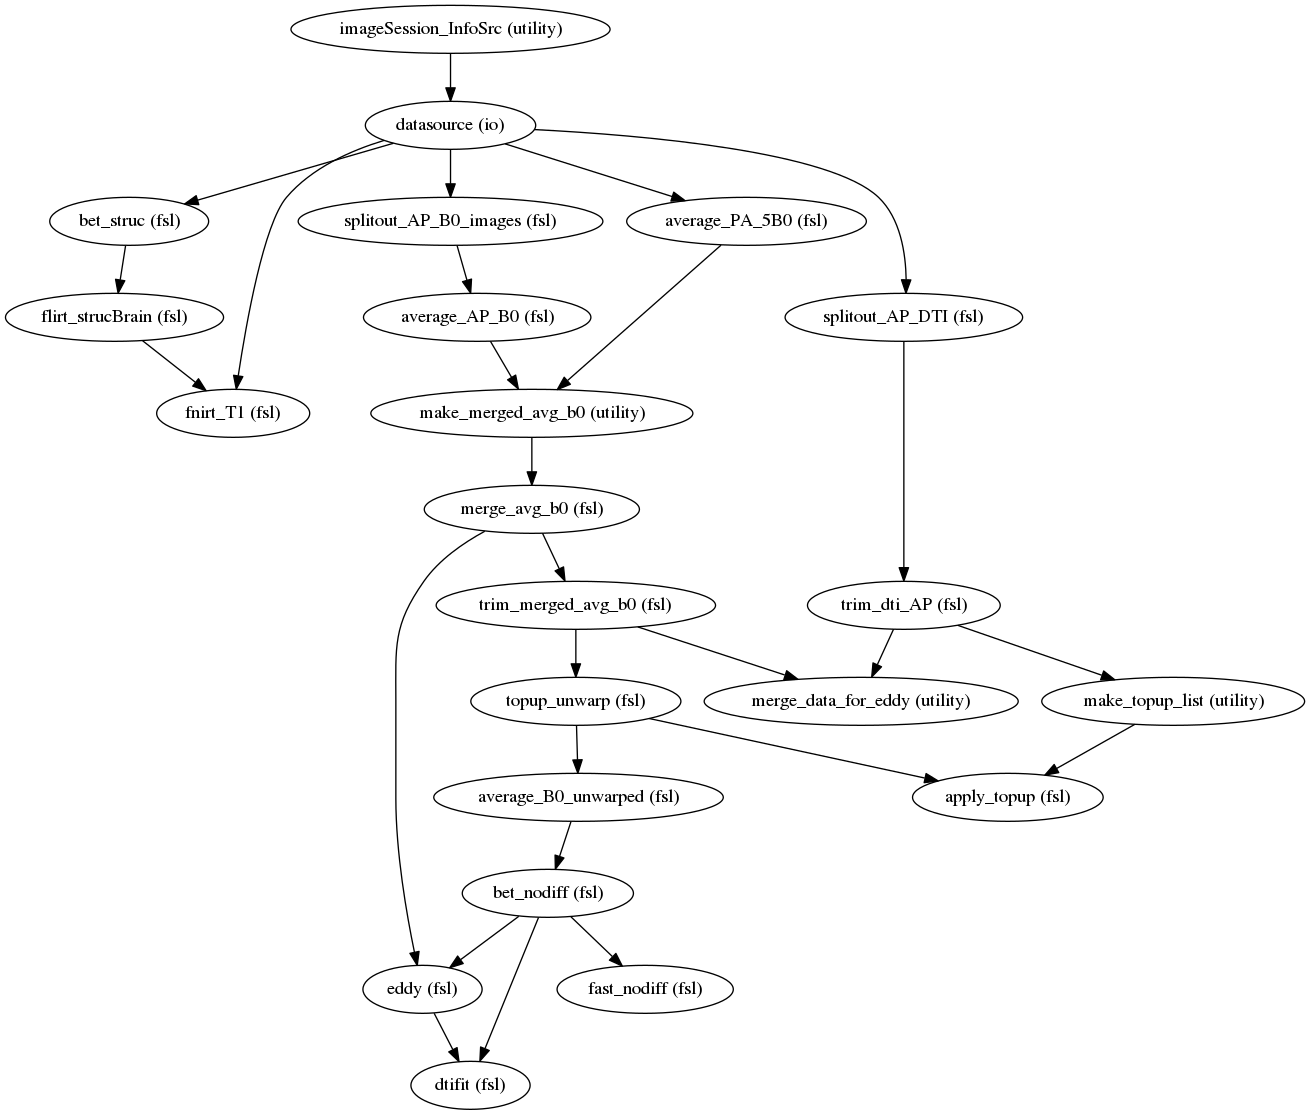

In [26]:
from IPython.display import Image
stoutPreProc_wf.write_graph('colored')

Image(filename='/FEATURES/NiPypeWorkingData/StoutHaber/niPypePreProc/stoutPreProc_wf/graph.dot.png') 

In [23]:

dt_file = stoutPreProc_wf.write_graph(graph2use='flat',simple_form=True)


#workflow.write_graph(graph2use='colored', format='svg', simple_form=True)

# orig shows only the main workflows and omits any subworkflows
# flat shows all workflows, including any subworkflows
# exec shows all workflows, including subworkflows and expands iterables into subgraphs
# hierarchical shows all workflows, including subworkflows and also shows the hierarchical structure
# colored gives


# I just opened an issue on networkx, but in the meantime I found a workaround that I thought worth sharing:
# 1-Install pydotplus (i.e. pip install pidotplus)
# 2-In nipype/pipeline/utils.py replace line 905 nx.write_dot(pklgraph, outfname) by nx.drawing.nx_pydot.write_dot(pklgraph, outfname)
# Now my dot files are generated just fine.

170127-16:32:27,603 workflow INFO:
	 Creating detailed dot file: /FEATURES/NiPypeWorkingData/StoutHaber/niPypePreProc/stoutPreProc_wf/graph_detailed.dot
170127-16:32:28,475 workflow INFO:
	 Creating dot file: /FEATURES/NiPypeWorkingData/StoutHaber/niPypePreProc/stoutPreProc_wf/graph.dot


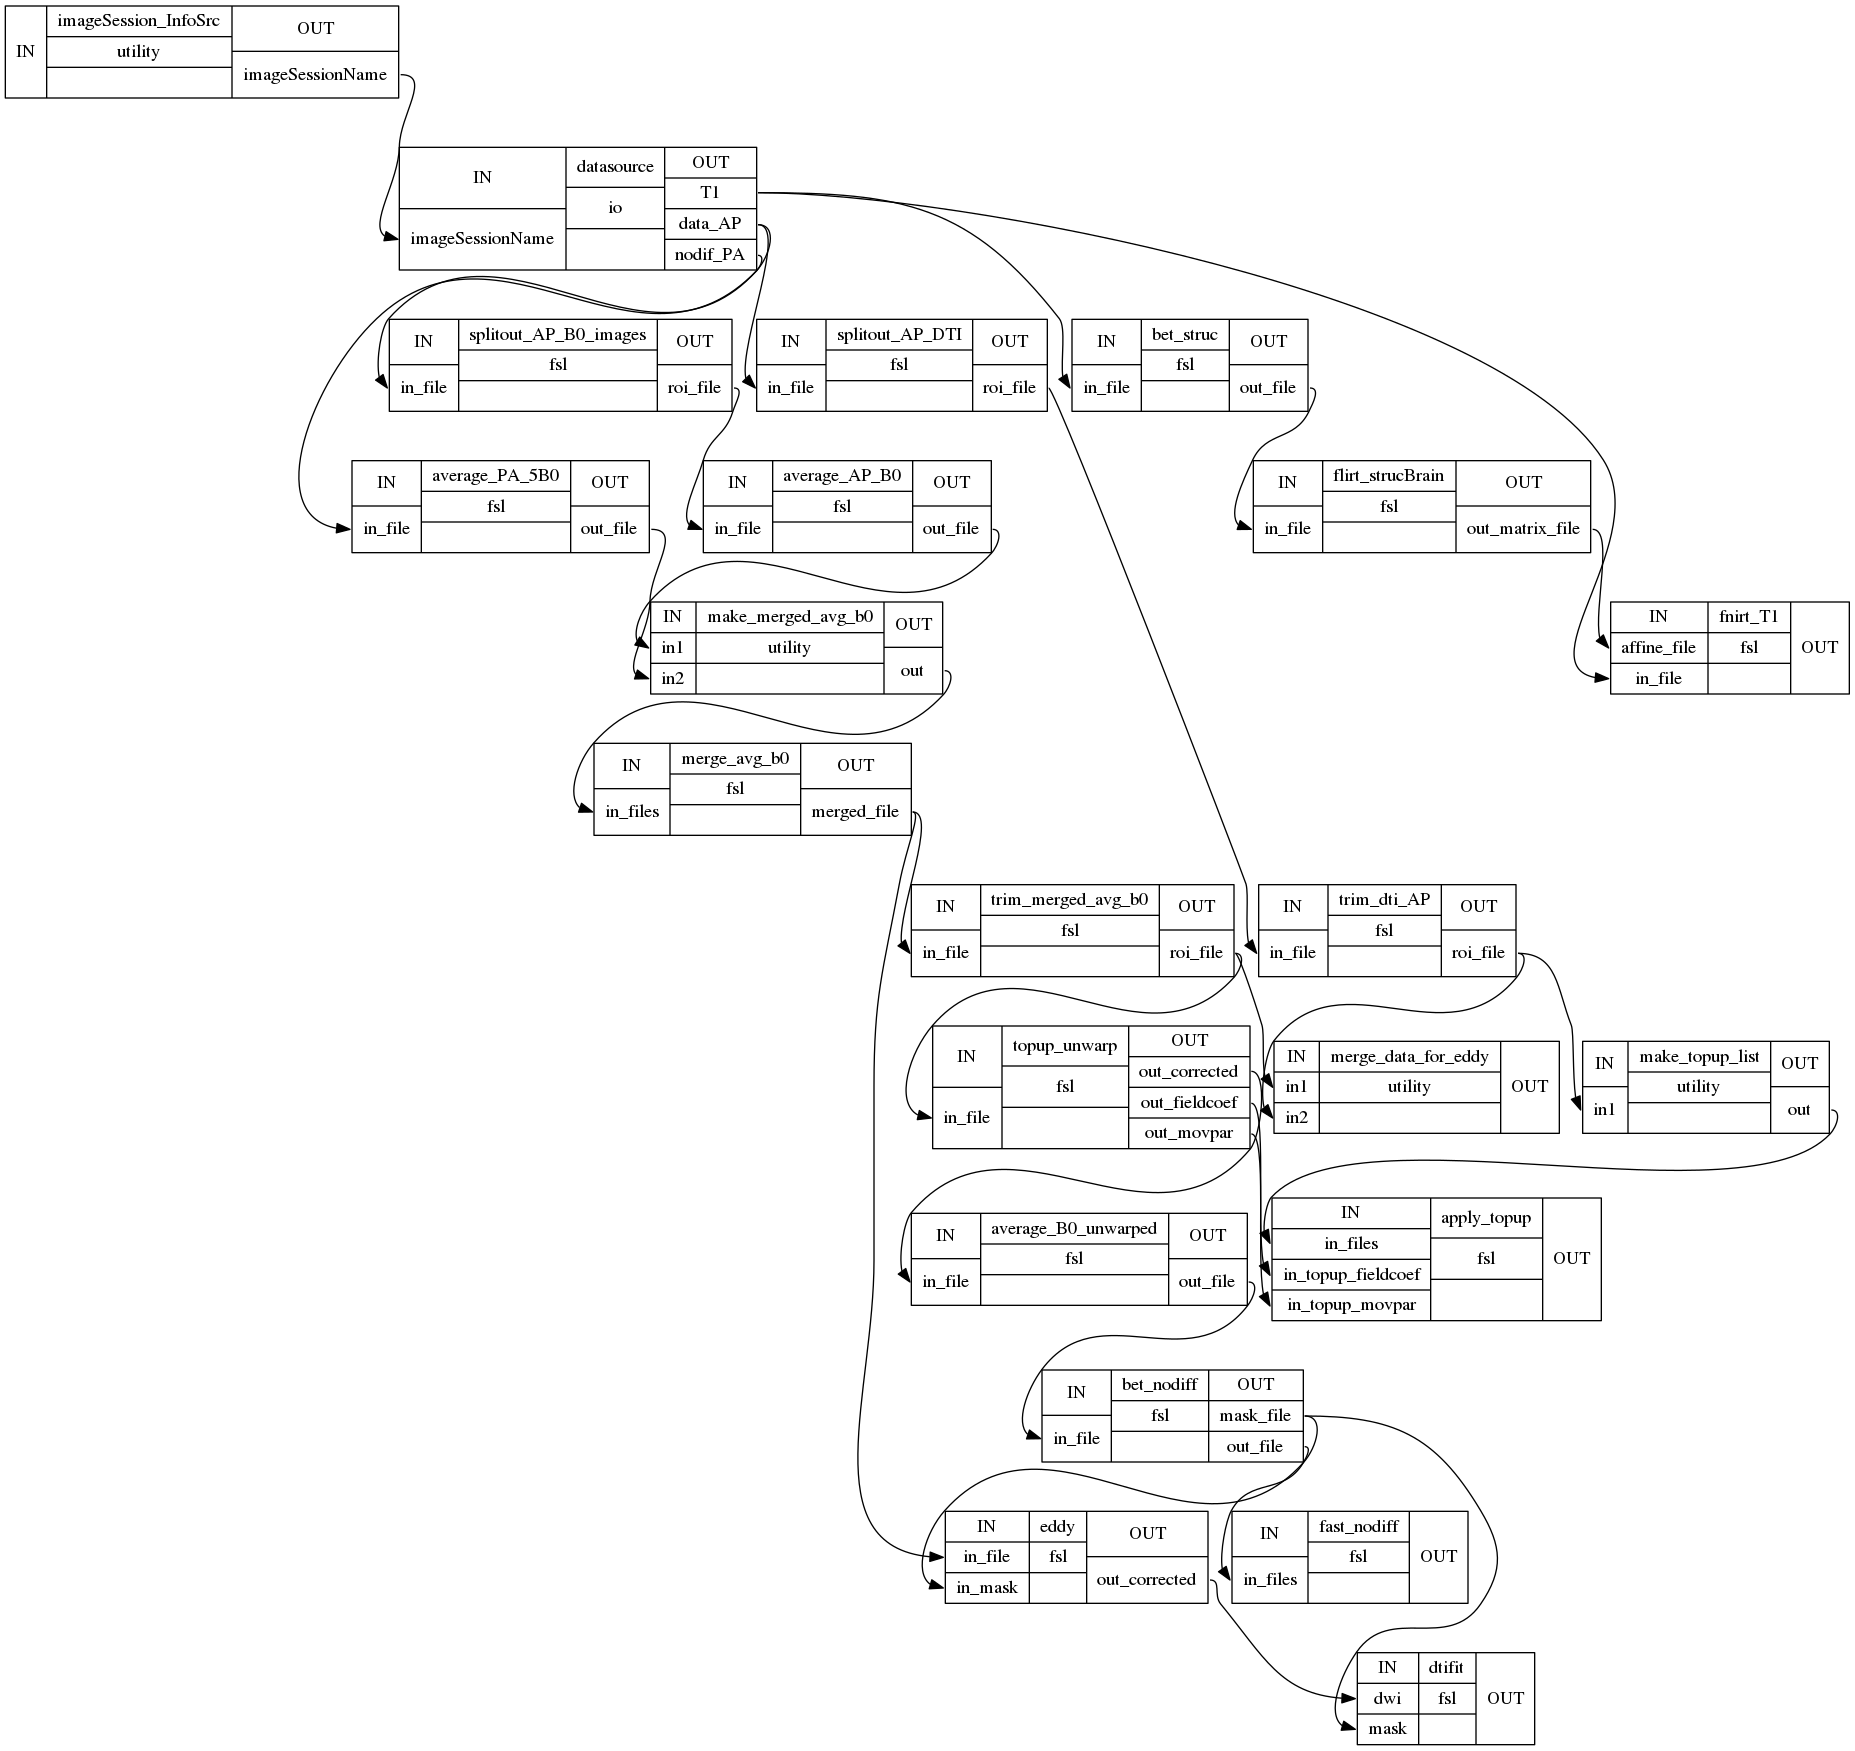

In [24]:
from IPython.display import Image
#Image(filename='/FEATURES/NiPypeWorkingData/StoutHaber/niPypePreProc/stoutPreProc_wf/graph_detailed.dot.png') 

Image(filename='/FEATURES/NiPypeWorkingData/StoutHaber/niPypePreProc/stoutPreProc_wf/graph_detailed.dot.png')
#Image(filename='/FEATURES/NiPypeWorkingData/StoutHaber/niPypePreProc_rafi/stoutPreProc_wf/graph.dot.png')

In [35]:
stoutPreProc_wf.run(plugin='PBS')





# stoutPreProc_wf.run(plugin='MultiProc', plugin_args={'n_procs' : 10})


170203-12:50:03,508 workflow INFO:
	 ['check', 'execution', 'logging']
170203-12:50:04,479 workflow INFO:
	 Running in parallel.
170203-12:50:04,511 workflow INFO:
	 Submitting 49 jobs
170203-12:50:04,512 workflow INFO:
	 Executing: datasource.a13 ID: 0
170203-12:50:04,752 workflow INFO:
	 Executing: datasource.a22 ID: 2
170203-12:50:04,902 workflow INFO:
	 Executing: datasource.a36 ID: 4
170203-12:50:05,58 workflow INFO:
	 Executing: datasource.a15 ID: 5
170203-12:50:05,217 workflow INFO:
	 Executing: datasource.a40 ID: 7
170203-12:50:05,383 workflow INFO:
	 Executing: datasource.a43 ID: 10
170203-12:50:05,493 workflow INFO:
	 Executing: datasource.a03 ID: 11
170203-12:50:05,659 workflow INFO:
	 Executing: datasource.a12 ID: 16
170203-12:50:05,830 workflow INFO:
	 Executing: datasource.a19 ID: 20
170203-12:50:05,979 workflow INFO:
	 Executing: datasource.a46 ID: 25
170203-12:50:06,142 workflow INFO:
	 Executing: datasource.a20 ID: 26
170203-12:50:06,303 workflow INFO:
	 Executing: dat

RuntimeError: Workflow did not execute cleanly. Check log for details

In [ ]:

## merge files
### first file is the output..
$statement  = " fslmerge -t $WORKINGDATAPATH/" .$subj[$i] . "/DTI/preprocess/merged_b0_AP-PA_dti_trim.nii.gz ";
$statement .= " $WORKINGDATAPATH/" .$subj[$i] . "/DTI/preprocess/merged_b0_AP-PA_trim.nii.gz ";
$statement .= " $WORKINGDATAPATH/" . $subj[$i] . "/DTI/preprocess/AP/dti_AP_trim.nii.gz ";
#print "$statement \n";  # will be input for eddy



In [ ]:
make_merged_b0_APPA_dti_trimmed = pe.Node( util.Merge(2), name='make_merged_b0_APPA_dti_trimmed' )



In [ ]:
# topup unwarping
$statement  = " topup ";
$statement .= " --imain=$WORKINGDATAPATH/" .$subj[$i] . "/DTI/preprocess/merged_b0_AP-PA_trim.nii.gz ";
$statement .= " --datain=$WORKINGDATAPATH/acq_params.txt ";
$statement .= " --config=/usr/share/fsl/5.0/etc/flirtsch/b02b0.cnf ";
$statement .= " --out=$WORKINGDATAPATH/" .$subj[$i] . "/DTI/preprocess/topup ";
$statement .= " --fout=$WORKINGDATAPATH/" .$subj[$i] . "/DTI/preprocess/topup_fieldmap "; # can be used for FEAT
$statement .= " --iout=$WORKINGDATAPATH/" .$subj[$i] . "/DTI/preprocess/merged_b0_unwarped.nii.gz ";

In [ ]:
# SplitME = fsl.Split(dimension='t')
# SplitME.inputs.in_file = '/FEATURES/NiPypeWorkingData/StoutHaber/NII_Data_Complete/Subj01_Scan1/DTI/preprocess/AP/data_AP.nii.gz'
# result = SplitME.run()
# print result.outputs.out_files

In [ ]:
#  http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.fsl.maths.html#meanimage

In [ ]:
from nipype.interfaces.utility import Function
# get AP avg b0

### I need to get the B0 images which come out of the FSL split and select the first
### several images needed for the average
def getB0images( input_files ):
    """This will return an image stack for merging """
    import os
    b0_Images = []
    b0_image_suffixes = [ 'vol0000.nii.gz','vol0001.nii.gz','vol0002.nii.gz','vol0003.nii.gz','vol0004.nii.gz',
                          'vol0005.nii.gz','vol0006.nii.gz']
    for fwp in input_files: #file w path
        if os.path.basename(fwp) in b0_image_suffixes:
            b0_Images.append(fwp)  ###means I found one of the b0 image files I wanted
    return b0_Images  ### List of images to merge
   
getB0images_interface = Function(input_names=["input_files"], output_names=["b0_image_list"], function=getB0images)

In [ ]:
# def getDiffimages( input_files ):  
#     """This will return an image stack for merging """
#     import os
#     b0_Images = []
#     b0_image_suffixes = [ 'vol0000.nii.gz','vol0001.nii.gz','vol0002.nii.gz','vol0003.nii.gz','vol0004.nii.gz',
#                           'vol0005.nii.gz','vol0006.nii.gz']
#     for fwp in input_files: #file w path
#         if os.path.basename(fwp) in b0_image_suffixes:
#             b0_Images.append(fwp)  ###means I found one of the b0 image files I wanted
#     return b0_Images  ### List of images to merge
   
# getB0images_interface = Function(input_names=["input_files"], output_names=["b0_image_list"], function=getB0images)